In [79]:
import pandas as pd
import pickle
import requests
import json
import os
import yaml
from watson_developer_cloud import DiscoveryV1, ToneAnalyzerV3, PersonalityInsightsV3
from collections import defaultdict
import re

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [81]:
credentials = yaml.load(open(os.path.expanduser('~/.ssh/watson_cred.yml')))

In [82]:
discovery = DiscoveryV1(
        username=credentials['WatsonDiscovery1']['username'],
        password=credentials['WatsonDiscovery1']['password'],
        version="2016-12-01")

In [83]:
environ = discovery.get_environments()
environ

{'environments': [{'created': '2017-06-02T17:23:28.167Z',
   'description': 'Watson News cluster environment',
   'environment_id': '32955422-7b8b-43f3-8962-0f43867427a1',
   'name': 'Watson News Environment',
   'read_only': True,
   'status': 'active',
   'updated': '2017-06-02T17:23:28.167Z'}]}

In [84]:
environ_id = environ['environments'][0]['environment_id']

In [85]:
environ_id

'32955422-7b8b-43f3-8962-0f43867427a1'

In [86]:
collection = discovery.list_collections(environ_id)
collection

{'collections': [{'collection_id': '14a7d9a5-8d64-4f91-ad17-3a6b2db45ba3',
   'configuration_id': '978d9807-6d1f-4cda-bb69-1b5c5df7e1a7',
   'created': '2017-06-02T17:23:28.261Z',
   'description': 'Watson News pre-enriched collection of curated news sources',
   'language': None,
   'name': 'watson_news',
   'status': 'active',
   'updated': '2017-06-02T17:23:28.261Z'}]}

In [12]:
collection_id = collection['collections'][0]['collection_id']

if: "language": "portuguese"

In [13]:
founders = {'Amr Shady':'Aingel',"in_your_corner":'Bea Arthur', 'Eric Ries':'LTSE', 'Sameer Al-Sakran':'Metabase',
           'KEN SO':'flowcast'}

In [14]:
qopts = {'query':'keywords.text:(Metabase)',
                  ,'filter':'entities.type::Company',
        'filter':'taxonomy.label:(business news|tech news|company|internet technology|operating systems|\
         consumer electronics|hardware)'}

SyntaxError: invalid syntax (<ipython-input-14-ba45a924d046>, line 2)

In [15]:
qopts = {'query':'keywords.text::(Jake Mendel)'
                 ,'filter':'entities.type::Person',
       'filter':'taxonomy.label:(business news|tech news|company)'}
                                 # {'entities.type::(Person, relevance>.5)',
#                                                        "taxonomy.label::(internet technology|operating systems|\
#                                                        progamming languages|software|tech news|company|business news|\
#                                                          consumer electronics|hardware)",
#                              'docEmotions::(anger|disgust|fear|joy|sadness)'
                                                     #},
      #  'count':15}
my_query = discovery.query(environ_id ,collection_id, qopts)
print(json.dumps(my_query, indent=2))

{
  "matching_results": 0,
  "results": []
}


In [16]:
my_query['results'][0].keys()

IndexError: list index out of range

In [237]:
[i['text'] for i in my_query['results']]

['×\n\n× Fechar\n\nValide seu voto\n\nOlá, Alexandre. sair\n\nSexta-feira, 21 de Abr de 2017\n\nSamarco quer suspensão temporária de trabalho\n\nAmália Goulart /  21/04/2017 - 06h00\n\nA Samarco propôs aos sindicatos de trabalhadores um novo período de layoff (suspensão temporária do contrato de trabalho). A intenção é deixar em casa por dois meses os funcionários, já que as operações estão paralisadas há cerca de um ano e meio, quando do rompimento da barragem de rejeitos de Fundão, em Mariana.\n\nOs sindicatos Metabase (Mariana) e Sindimetal (ES) votam, na próxima semana, se aceitam ou recusam a proposta da empresa. Hoje, a Samarco possui cerca de 1.800 funcionários. Eram 3 mil. Mas, desde que ocorreu a tragédia, 1.200 foram demitidos por meio de Programa de Demissão Voluntária (PDV).\n\nÉ o terceiro layoff que a empresa lança. A Samarco esclareceu que, neste período, os trabalhadores terão bolsa de qualificação profissional e receberão o mesmo valor líquido dos salários. “A solução 

In [63]:
[i['id'] for i in my_query['results']]

['6d43aefcd35f353d8b70d3231663fa61']

# Tone  + Big5 analyzer
- Only look at the CEO of each company

In [17]:
steve_jobs_text =open("../data/raw/original_content_tech_mbti/steve_jobs:istp",'r').read()
jonathan_ive_text = open("../data/raw/original_content_tech_mbti/jonathan_ive:isfp",'r').read()
mark_cuban_text = open("../data/raw/original_content_tech_mbti/mark_cuban:esfp",'r').read()

In [18]:
eric_reis_sentences = ["very sad that i can't be in 🇬🇧🇬🇧🇬🇧in person this year - but will do my best remotely.",
 'see you soon!',
 "  i don't know what they will do, but i do know the hot takes aren't talking about this.",
 ' "you too can be like steph curry" by trading cash for equity :)',
 'can you use the us amazon site?',
 ' we shall see!',
 ' yes, but now that we know how powerful it is, why not use it as a strategy?',
 '3/i trust the analogy to startups is clear',
 "2/and even among the ones who do, i've yet to see one suggest this as a conscious strategy.",
 'why does lebron really want any salary at all?',
 "1/i'm surprised how many analyses of the warriors neglect to mention how much is made possible by curry's sub-market contract",
 ' i was in the arena last night and thinking of the lessons from your book.',
 'absolutely, brilliantly on display',
 ' excellent subtweet',
 ' method acting',
 ' why is something going on at uber?',
 ' many of their conference rooms are named after sci-fi dystopias.',
 'so maybe not unintentional?',
 'global eir and silicon valley bank funding match - kudos',
 ' ads are micropayments',
 'the startup way is coming out this fall but is available for pre-order now:',
 '  generations of kids will learn about quo warranto in history class',
 '     thanks for getting right on it.',
 'sorry for the mid-weekend fire drill',
 "     here's another clue: if i click around the site, i see normal lin…",
 "     i'm on ios and always view inside twitter.",
 "don't think any ad blo…",
 '     always shows same set of (very old) links.',
 'used to be a mix of to…',
 "    don't mean to take away from your excellent reporting, just thought you'd want to know",
 "the ultimate dog that didn't bark",
 '  hey this is minor but the "more from /" box at the bottom of articles has been broken for a couple wks',
 ' great minds think alike?',
 '     are you guys ruining basketball too?',
 '     all-star super team',
 "he's baaaaack",
 ' happy birthday!',
 'my new book, the startup way, is available for pre-order here:',
 "i've learned a ton about basketball from  and  since jumping on the gsw bandwagon",
 'in all seriousness, has anyone written about russian involvement in the u.k. this year?',
 '\n\njune 13 &amp; 14 👉',
 ' starting with holding a 50% brexit referendum in the first place',
 '   bravo, congrats, kudos!',
 'i got to read an early draft of this and am very excited for it to reach a wider audience.',
 'pre-order here:',
 'test a new finance tool for founders.',
 '   interview  would be an amazing pairing',
 '\n\ncoming to ios 11 and macos 10.11, 10.12, &amp; 10.13!',
 '  ever rotated your phone while sending an sms?',
 '     fedcoin will have tuned inflation and a real-life use case, disint…',
 '     one day a central bank will realize they can release a block to co…',
 ' hyper podcast is what people want!',
 'discussion of tldr options still going strong',
 'hacker news discussion of tldr options',
 'what do you think of this?',
 'confusing?',
 ' yup we have been testing this with customers (employees) to try and find the sweet spot between too much and too little info',
 " we subtly incorporate that info into the page, but we don't make the ev explicit",
 'my thoughts on tldr options on  cc',
 'ever tried to figure out what your stock options are worth, and found it baffling?',
 'my new book, the startup way, is available for pre-order now:',
 "we've launched",
 "what's awesome (and depressing at the same time) about this is it just keeps going and going...",
 ' explored in some depth in this science/fanfic crossover:',
 'honored to have you!',
 'whoa is right',
 'pre-order my new book, the startup way, here:',
 ' profoundly disturbing.',
 "i can't believe it's real",
 " goddamnit you're right (again)",
 ' i guess we can still use it as a euphemism for going to prison',
 ' we\'re going to have to stop using "in like flynn"',
 ' is a really good writer',
 'super excited for this one',
 'honored to accept this award on behalf of the whole  team of amazing volunteers\n\n(ps gotta love a company…',
 '   more like 0wn3d',
 'my new book, the startup way, is coming out this fall from crown biz:',
 'rare bipartisan agreement',
 '  hahahahhaha',
 ' every time',
 '     way better than a #ff!',
 '  who is your wallbreaker?',
 'incredible',
 'sophon could be listening',
 '  what do you need?',
 ' deities maybe feeling - wth some justification - that subtle signs are not being heeded',
 '    👏🏽👏🏽👏🏽',
 'the startup way, my next book coming this fall, is available for pre-order now:',
 'this should be amazing',
 'immigrants, they get the job done',
 ' black sails',
 'insightful discussion w/ on the need to question our assumptions about great leadership',
 'want software to help you run your startup?',
 'too much news every day.',
 'these latest revelations are nuts',
 ' singular?',
 "don't tempt fate",
 ' i know it must be exhausting to do these mini essays but they really are helpful.',
 "i'm excited to share my new book, the startup way, with you this fall.",
 'pre-order available now:',
 ' most chilling moment',
 'offered without comment.',
 'what is there left to say?',
 ' amen to that',
                    '  test a new finance tool for founders.',
 ' great thread',
 'check out my new book, the startup way, coming out this october:',
 '  bravo, admirably clear analysis',
 'congrats  &amp;  on hacking growth!',
 'i’m giving away five copies, tell me why you want one here:',
 '  oh perfect!',
 'thank you!',
 ' would you give us an api to this data so we can incorporate it into  ?',
 'looking forward to sharing the startup way with you this fall.',
 'in the meantime you can pre-order it here:',
 'wish that founders had better software tools?',
 ' he confronts it every day in his office.',
 'fact check true',
 'my new book, the startup way, is coming out this fall.',
 'check it out here:',
 ' nothing unreal exists',
 '  very different by category/genre as i understand it',
 'congrats on the launch',
 'people like science',
 'my new book is coming soon...pre-order the startup way here:',
 'such a great combination!',
 'my new book is coming soon...pre-order the startup way here:',
 'the startup way is coming this fall from crown biz.',
 'check it out here:',
 ' just reply "less" to the bot',
 " don't do it!",
 '   wish i could be there - the live tweets are amazing',
 ' otoh i once tried to give away this great idea for a twitter parody account',
 " seriously - it's actually a very easy delusion to cure if you try",
 'send a 💌to congress, the easiest way possible',
 ' was it signed "money receptacle?"',
 "\n1) it's not too much effort\n2) it reduces risk or improves exploration\n3) coordinating is…",
 "can't do science sans hypothesis",
 ' (born in 1978 here, so feel your pain)',
 " i'll tell you who has time for that - millennials, that's who",
 '“how we got 10 million teens to read fiction on their phones” by',
 '  oh of course totally agree.',
 "just think it's remarkable how we &amp; press just take that for granted",
 "  what's astonishing is the zero concern paid to ethics, duty, patriotism, etc",
 '  congrats on pub!',
 "isn't that how the human bodies people do it?",
 'anyone know what this guy is talking about?',
 'this looks amazing',
 '\n\nwhy fewer companies are going public, why it matters, and what we can do about it.',
 '    marginal districts where incumbency effect is larger than the…',
 'the startup way is coming your way in october!',
 'pre-order here:',
 ' still not over it',
 '  huge congrats!',
 'so well deserved']

In [19]:
len( ' 👊🏼',)

3

In [117]:
def aggregated_tone_analyzer(sentences_list):
    """Takes in a list of sentences and and outputs the average Emotioinal Tones (anger, disgust, fear, joy, sadness),
    Social Tones (openess, conscientiousness, extraversion, agreeableness, emotional range) 
    across all of the input sentences.
    
    Returns a dictionary of emotional_tones, language_tones, then social tones.
    
    Assumes you have imported the ToneAnalyzerV3 from the Watson APIs.
    
    Feeds in  one hundred sentences at a time to the Watson API"""
    # Authenticate the Watson API
    credentials_tone= yaml.load(open(os.path.expanduser('~/.ssh/watson_cred.yml')))
    tone_analyze = ToneAnalyzerV3(
        username=credentials_tone['ToneAnalyzerV3']['username'],
        password=credentials_tone['ToneAnalyzerV3']['password'],
        version="2016-12-01")
    # store the results
    emotional_tones = defaultdict(int)
    language_tones = defaultdict(int)
    social_tones = defaultdict(int)
    total_num_sentences = len(sentences_list)
    print(f"Total number of sentences to be analyzed = {total_num_sentences }")
    # store the chuncks of sentences
    sentences_chunk = ""
    number_of_chunks = 0
    for idx,sent in enumerate(sentences_list):
        sentences_chunk+=str(sent)
        
        if (idx %100 == 0) and (idx !=0) or (idx +1 == total_num_sentences ): # perform analysis

            response = tone_analyze.tone(sentences_chunk)
            # append the score for emotional tones
            for emot_tone in response['document_tone']['tone_categories'][0]['tones']:
                # 0 is emotion , 1 is language 2 = social
                emotional_tones[emot_tone['tone_id']]+= emot_tone['score']
            # append the scores for the language tones
            for lang_tone in response['document_tone']['tone_categories'][1]['tones']:
                # 0 is emotion , 1 is language 2 = social
                language_tones[lang_tone['tone_id']]+= lang_tone['score']
            #append the scores for the social tones
            for social_tone in response['document_tone']['tone_categories'][2]['tones']:
                # 0 is emotion , 1 is language 2 = social
                social_tones[social_tone['tone_id']]+= social_tone['score']
            print(f"{idx} sentences analyzed")
            number_of_chunks +=1

            if idx+1 == total_num_sentences : # finished
                # compute the average
                for emot_tone in response['document_tone']['tone_categories'][0]['tones']:
                    emotional_tones[emot_tone['tone_id']] /= number_of_chunks 
                for lang_tone in response['document_tone']['tone_categories'][1]['tones']:
                    language_tones[lang_tone['tone_id']] /= number_of_chunks  
                for social_tone in response['document_tone']['tone_categories'][2]['tones']:
                    social_tones[social_tone['tone_id']] /= number_of_chunks 

    
    
                
    return emotional_tones , language_tones , social_tones 

In [88]:
vc1_pitchbook_df = pd.read_csv( "../data/processed/PitchBook_CA_VCInvest=1.csv")

In [89]:
vc1_pitchbook_df .head(1)

,Unnamed: 0,Company ID,Description,Company Name,HQ Post Code,Primary Industry Code,Primary Contact,Year Founded,Active Investors,HQ Location,...,Last Financing Date,Last Financing Size,Last Financing Deal Type 2,Majestic Referring Domains,Facebook Likes,Twitter Followers,Employees,Total Raised,VC_invested,Twitter_Username
0,0,61743-97,Developer of an online advertisement platform ...,ZypMedia,94102,Social/Platform Software,Mark Goldman,2013.0,"Sinclair Broadcast Group, Sinclair Digital Ven...","San Francisco, CA",...,2015-04-24,4.42,Series B,115.5,1135.0,51.0,12.0,6.82,1,mgold54


In [30]:
# find the twitter text for each person, fun text through the Watson APIs, and return new features

In [49]:
Twitter_Username = 'anthemos'

In [50]:
Primary_Contact = "Anthemos Georgiades"

In [51]:
Company_name = "Zumper"

In [52]:
search = Company_name +"-"+Primary_Contact+"-"+Twitter_Username 

In [53]:
search

'Zumper-Anthemos Georgiades-anthemos'

In [118]:
def add_nlp_features(input_df):
    """Feed in a dataframe that contains the company name, primary contact, and primary contacts twitter handle.
    Opens up the text file from that Twitter handle and runs it through the Watson APIs to get features on
    emotional, language, and social tones. 
    
    Returns a the dataframe with these features appended."""
    total_rows = len(input_df)
    final_df = input_df.copy()
    
    language_tones_analytical = []
    language_tones_confident = []
    language_tones_tentative = []
    
    emotional_tones_anger = [] 
    emotional_tones_disgust = []
    emotional_tones_fear = []
    emotional_tones_joy = []
    emotional_tones_sadness = []
    
    social_tones_agreeableness_big5 = []
    social_tones_conscientiousness_big5 = []
    social_tones_emotional_range_big5 = []
    social_tones_extraversion_big5 = []
    social_tones_openness_big5 = []
    
    
    
    for idx,row in enumerate(input_df.iterrows()): # go through each founder
        handle = row[1]['Twitter_Username']
        print(handle)
        primary_contact = row[1]['Primary Contact']
        company = row[1]['Company Name']
        search = company +"-"+primary_contact+"-"+handle
        
        with open(f"../data/raw/founders_tweets/vc_invest=1/{search}",'rb') as fp: # open up founder text
            text_data = pickle.load(fp)
        emotional, language, social = aggregated_tone_analyzer(text_data)
        emotional_tones_anger.append(emotional['anger'])
        emotional_tones_disgust.append(emotional['disgust'])
        emotional_tones_fear.append(emotional['fear'])
        emotional_tones_joy.append(emotional['joy'])
        emotional_tones_sadness.append(emotional['sadness'])
        
        language_tones_analytical .append(language["analytical"])
        language_tones_confident .append(language["confident"])
        language_tones_tentative.append(language["tentative"])
        
        social_tones_agreeableness_big5 .append(social["agreeableness_big5"])
        social_tones_conscientiousness_big5 .append(social["conscientiousness_big5"])
        social_tones_emotional_range_big5 .append(social["emotional_range_big5"])
        social_tones_extraversion_big5 .append(social["extraversion_big5"])
        social_tones_openness_big5.append(social["openness_big5"])
        
        if (idx % 10 == 0) & (idx >0):
            print(f"{idx/total_rows:%.2} finished")
            
    # language Tones            
    final_df['analytical'] = language_tones_analytical
    final_df['confident'] = language_tones_confident
    final_df['tentative'] = language_tones_tentative
    # emotional tones
    final_df['anger'] = emotional_tones_anger
    final_df['disgust'] = emotional_tones_disgust
    final_df['fear'] = emotional_tones_fear
    final_df['joy'] = emotional_tones_joy
    final_df['sadness'] = emotional_tones_sadness
    # Big 5 personality 
    final_df['agreeableness_big5'] = social_tones_agreeableness_big5
    final_df['conscientiousness_big5'] = social_tones_conscientiousness_big5
    final_df['emotional_range_big5'] = social_tones_emotional_range_big5
    final_df['extraversion_big5'] = social_tones_extraversion_big5
    final_df['openness_big5'] =  social_tones_openness_big5
    
    return final_df

In [119]:
final_df_nlp = add_nlp_features(vc1_pitchbook_df.iloc[:10,:] )

mgold54
Total number of sentences to be analyzed = 32
31 sentences analyzed
sbaksh
Total number of sentences to be analyzed = 15
14 sentences analyzed
notEricMin
Total number of sentences to be analyzed = 252
100 sentences analyzed
200 sentences analyzed
251 sentences analyzed
sshadfar
Total number of sentences to be analyzed = 129
100 sentences analyzed
128 sentences analyzed
anthemos
Total number of sentences to be analyzed = 2993
100 sentences analyzed
200 sentences analyzed
300 sentences analyzed
400 sentences analyzed
500 sentences analyzed
600 sentences analyzed
700 sentences analyzed
800 sentences analyzed
900 sentences analyzed
1000 sentences analyzed
1100 sentences analyzed
1200 sentences analyzed
1300 sentences analyzed
1400 sentences analyzed
1500 sentences analyzed
1600 sentences analyzed
1700 sentences analyzed
1800 sentences analyzed
1900 sentences analyzed
2000 sentences analyzed


WatsonException: Error: Input text exceeded API limit of 1,000 sentences, Code: 400

In [116]:
.0088 *  400 * 15

52.8

In [ ]:
.0088 * 

In [103]:
final_df_nlp .columns

Index(['Unnamed: 0', 'Company ID', 'Description', 'Company Name',
       'HQ Post Code', 'Primary Industry Code', 'Primary Contact',
       'Year Founded', 'Active Investors', 'HQ Location', 'Growth Rate',
       'Size Multiple', 'Last Financing Date', 'Last Financing Size',
       'Last Financing Deal Type 2 ', 'Majestic Referring Domains',
       'Facebook Likes', 'Twitter Followers', 'Employees', 'Total Raised',
       'VC_invested', 'Twitter_Username', 'analytical', 'confident',
       'tentative', 'anger', 'disgust', 'fear', 'joy', 'sadness',
       'agreeableness_big5', 'conscientiousness_big5', 'emotional_range_big5',
       'extraversion_big5', 'openness_big5'],
      dtype='object')

In [108]:
final_df_nlp.iloc[1,:]

Unnamed: 0                                                                     6
Company ID                                                              62229-34
Description                    Developer of animated, interactive learning ma...
Company Name                                                              Zyante
HQ Post Code                                                               95031
Primary Industry Code                                                 Publishing
Primary Contact                                                     Smita Bakshi
Year Founded                                                                2012
Active Investors               Bialla Venture Partners, National Science Foun...
HQ Location                                                        Los Gatos, CA
Growth Rate                                                            0.0789525
Size Multiple                                                           0.760068
Last Financing Date         

In [25]:
lang

defaultdict(int,
            {'analytical': 0.456733, 'confident': 0.0, 'tentative': 0.3868775})

In [24]:
emot

defaultdict(int,
            {'anger': 0.09781100000000001,
             'disgust': 0.0706905,
             'fear': 0.114054,
             'joy': 0.6394489999999999,
             'sadness': 0.544365})

In [181]:
soc

defaultdict(int,
            {'agreeableness_big5': 0.464886,
             'conscientiousness_big5': 0.7319415,
             'emotional_range_big5': 0.555707,
             'extraversion_big5': 0.6656839999999999,
             'openness_big5': 0.5564235})

In [140]:
response_eric_ries = tone_analyze.tone( """very sad that i can't be in 🇬🇧🇬🇧🇬🇧in person this year - but will do my best 
                                       remotely.see you soon!  i don't know what they will do, but i do know the hot
                                       takes aren't talking about this. "you too can be like steph curry" by trading cash 
                                       for equity :)can you use the us amazon site? we shall see! yes, but now that we know 
how powerful it is, why not use it as a strategy?3/i trust the analogy to startups is clear2/and even among the ones
who do, i've yet to see one suggest this as a conscious strategy.why does lebron really want any salary 
at all?1/i'm surprised how many analyses of the warriors neglect to mention how much is made possible by
curry's sub-market contract i was in the arena last night and thinking of the lessons from your
book.absolutely, brilliantly on display excellent subtweet method acting why is something going 
on at uber? many of their conference rooms are named after sci-fi dystopias.so maybe 
not unintentional?global eir and silicon valley bank funding match - kudos ads are micropaymentsthe
startup way is coming out this fall but is available for pre-order now:  generations of kids will learn
    about quo warranto in history class     thanks for getting right on it.sorry for the mid-weekend fire drill 
    here's another clue: if i click around the site, i see normal lin…     i'm on ios and always view inside
    twitter.don't think any ad blo…     always shows same set of (very old) links.used to be a mix of to…   
    don't mean to take away from your excellent reporting, just thought you'd want to knowthe ultimate dog
    that didn't bark  hey this is minor but the "more from /" box at the bottom of articles has been broken
    for a couple wks great minds think alike?     are you guys ruining basketball too?     all-star super 
    teamhe's baaaaack happy birthday!my new book, the startup way, is available for pre-order here:i've learned
    a ton about basketball from  and  since jumping on the gsw bandwagonin all 
                    seriousness, has anyone written about russian involvement in the u.k. this year?""")

# End of Current Work

In [141]:
[(i,'here') for i in response_eric_ries['document_tone']['tone_categories']] # test angry

[({'category_id': 'emotion_tone',
   'category_name': 'Emotion Tone',
   'tones': [{'score': 0.166655, 'tone_id': 'anger', 'tone_name': 'Anger'},
    {'score': 0.086693, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
    {'score': 0.091384, 'tone_id': 'fear', 'tone_name': 'Fear'},
    {'score': 0.665743, 'tone_id': 'joy', 'tone_name': 'Joy'},
    {'score': 0.588614, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
  'here'),
 ({'category_id': 'language_tone',
   'category_name': 'Language Tone',
   'tones': [{'score': 0.589709,
     'tone_id': 'analytical',
     'tone_name': 'Analytical'},
    {'score': 0.0, 'tone_id': 'confident', 'tone_name': 'Confident'},
    {'score': 0.435991, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
  'here'),
 ({'category_id': 'social_tone',
   'category_name': 'Social Tone',
   'tones': [{'score': 0.505682,
     'tone_id': 'openness_big5',
     'tone_name': 'Openness'},
    {'score': 0.425775,
     'tone_id': 'conscientiousness_big5',
     'tone_nam

In [23]:
[(i,'here') for i in response['document_tone']['tone_categories']] # mark cuban

[({'category_id': 'emotion_tone',
   'category_name': 'Emotion Tone',
   'tones': [{'score': 0.037566, 'tone_id': 'anger', 'tone_name': 'Anger'},
    {'score': 0.084632, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
    {'score': 0.156719, 'tone_id': 'fear', 'tone_name': 'Fear'},
    {'score': 0.01439, 'tone_id': 'joy', 'tone_name': 'Joy'},
    {'score': 0.814887, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
  'here'),
 ({'category_id': 'language_tone',
   'category_name': 'Language Tone',
   'tones': [{'score': 0.243971,
     'tone_id': 'analytical',
     'tone_name': 'Analytical'},
    {'score': 0.922197, 'tone_id': 'confident', 'tone_name': 'Confident'},
    {'score': 0.0, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
  'here'),
 ({'category_id': 'social_tone',
   'category_name': 'Social Tone',
   'tones': [{'score': 0.037333,
     'tone_id': 'openness_big5',
     'tone_name': 'Openness'},
    {'score': 0.020809,
     'tone_id': 'conscientiousness_big5',
     'tone_name

In [28]:
[(i,'here') for i in response['document_tone']['tone_categories']] # jonathan ive

[({'category_id': 'emotion_tone',
   'category_name': 'Emotion Tone',
   'tones': [{'score': 0.111351, 'tone_id': 'anger', 'tone_name': 'Anger'},
    {'score': 0.085619, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
    {'score': 0.121887, 'tone_id': 'fear', 'tone_name': 'Fear'},
    {'score': 0.522126, 'tone_id': 'joy', 'tone_name': 'Joy'},
    {'score': 0.505504, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
  'here'),
 ({'category_id': 'language_tone',
   'category_name': 'Language Tone',
   'tones': [{'score': 0.806758,
     'tone_id': 'analytical',
     'tone_name': 'Analytical'},
    {'score': 0.0, 'tone_id': 'confident', 'tone_name': 'Confident'},
    {'score': 0.730722, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
  'here'),
 ({'category_id': 'social_tone',
   'category_name': 'Social Tone',
   'tones': [{'score': 0.745981,
     'tone_id': 'openness_big5',
     'tone_name': 'Openness'},
    {'score': 0.491373,
     'tone_id': 'conscientiousness_big5',
     'tone_nam

In [37]:
[(i,'here') for i in response['document_tone']['tone_categories']] # steve jobs

[({'category_id': 'emotion_tone',
   'category_name': 'Emotion Tone',
   'tones': [{'score': 0.139301, 'tone_id': 'anger', 'tone_name': 'Anger'},
    {'score': 0.100833, 'tone_id': 'disgust', 'tone_name': 'Disgust'},
    {'score': 0.131111, 'tone_id': 'fear', 'tone_name': 'Fear'},
    {'score': 0.561573, 'tone_id': 'joy', 'tone_name': 'Joy'},
    {'score': 0.542079, 'tone_id': 'sadness', 'tone_name': 'Sadness'}]},
  'here'),
 ({'category_id': 'language_tone',
   'category_name': 'Language Tone',
   'tones': [{'score': 0.435398,
     'tone_id': 'analytical',
     'tone_name': 'Analytical'},
    {'score': 0.0, 'tone_id': 'confident', 'tone_name': 'Confident'},
    {'score': 0.422842, 'tone_id': 'tentative', 'tone_name': 'Tentative'}]},
  'here'),
 ({'category_id': 'social_tone',
   'category_name': 'Social Tone',
   'tones': [{'score': 0.618849,
     'tone_id': 'openness_big5',
     'tone_name': 'Openness'},
    {'score': 0.652386,
     'tone_id': 'conscientiousness_big5',
     'tone_nam

# Personality Insights

## Get search terms

In [ ]:
founders_companies = """Amr_Shady:Aingel




"""

In [9]:
companies = pd.read_csv('SVB Niche Finder Example Companies - Yes_DisoveryNews.csv')

In [10]:
companies_set1 = companies.iloc[:2]

In [16]:
companies.head()

,Watson Discovery Query Term,Watson Discovery Filter Term,Wiki Page Title,Company,Sales SubSector,Sales Niche,Unnamed: 6
0,Amazon.com,NaN,Amazon.com,Amazon,Commerce,e-Commerce,NaN
1,Jet.com,NaN,Jet.com,Jet,Commerce,e-Commerce,NaN
2,Fab.com,e-commerce,Fab (website),Fab,Commerce,e-Commerce,NaN
3,Lyst,NaN,Lyst,Lyst,Commerce,e-Commerce,NaN
4,Baublebar,NaN,Baublebar,Baublebar,Commerce,Retail Brands,NaN


In [13]:
#test_companies

In [14]:
def update_query_log(query_log,query_options,query=None):
    '''updates a dictionary that keeps track of 
    whether or not a query to DiscoveryNews was successful and, if it was,
    stores the number of results returned by the query'''
    
    company = query_options['query']
    print(company)
    
    #if company not in query_log.keys():
        #co_index = 1
        #query_log[company] = {}
        #query_log[company+"_1"]['query_count'] = co_index
         
    #else:
        #query_log[company+"_1"]['query_count']+=1
        #co_index = query_log[company+"_1"]['query_count']
        #query_log[company+'_'+str(co_index)] = {}
        
    query_log[company] = {}
    
    if query == None:
        query_log[company]['total_results'] = 'query_error'
        query_log[company]['returned_results'] = 'query_error'
    else:
        query_log[company]['total_results'] = query['matching_results']
        query_log[company]['returned_results'] = len(query['results'])
        
    return query_log

In [17]:
query_options = {'query':'Jet.com'}
q = discovery.query(environ_id, collection_id, query_options)

In [33]:
filename = './NewsResults/'+companies['Company'][1]+'.pickle'
with open(filename,'wb') as handle:
    pickle.dump(q, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
#TO READ THE PICKLED DICTIONARY BACK IN
with open(filename, 'rb') as handle:
    b = pickle.load(handle)

In [24]:
q

{'matching_results': 2646,
 'results': [{'ac_suggest': ['Login',
    'User',
    'Access code',
    'Social network service',
    'Walmart',
    'Facebook',
    'USA',
    'Washington',
    'Log Out',
    'USA TODAY',
    'social network',
    'Google',
    'in-store pickup orders',
    'online in-store pickup',
    'Best-Selling Books',
    'Facebook  Email  Twitter',
    'Photo galleries',
    'News tips',
    'print edition subscriber',
    'Google+  LinkedIn  Pinterest',
    'Facebook feed',
    'Facebook Sign',
    'Walmart',
    'Open settings',
    'Close settings',
    'home delivery',
    'account settings',
    'digital access',
    'social network',
    'Conversation Guidelines',
    'discounts',
    'Google Sign',
    'email address',
    'Thanks',
    'Newsstand',
    'USA',
    'Interactives',
    'Moonlighting',
    'Apps',
    'Crosswords',
    'Jet.com',
    'Corrections'],
   'alchemyapi_text': "Walmart to offer discounts for online in-store pickup orders\n \n\nSUBSCR

In [11]:
pickle.HIGHEST_PROTOCOL()

TypeError: 'int' object is not callable

In [36]:
def query_DiscoveryNews(companies_DF,results_per_company):
    
    query_log = {}
    news_niches_df = None
    
    for i in range(len(companies_DF)):

        row = pd.DataFrame(companies_DF.ix[i]).T
        query_options={}
        query_options['query'] = row['Watson Discovery Query Term'][i]
        
        if type(row['Watson Discovery Filter Term'][i])==str:
            query_options['filter'] = row['Watson Discovery Filter Term'][i]
        query_options['count'] = results_per_company

        
        try: 
            my_query = discovery.query(environ_id, collection_id, query_options)
            #print('query_log_a = ', query_log)
            
            filename = './NewsResults/'+companies['Company'][i]+'.pickle'
            with open(filename,'wb') as handle:
                pickle.dump(my_query, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
            #update query_log
            query_log = update_query_log(query_log,query_options,my_query)
            
            #print('query_log_b = ', query_log," i=",i)
        
        except:
            print('could not query company')
            query_log = update_query_log(query_log,query_options)
            continue
            
            #try: 
                #send my_query to S3 bucket using boto and json dumps
            
            #build text corpus data frame 
            
        try:
            company = query_options['query']
            subsector = companies[companies['Watson Discovery Query Term'] == company]['Sales SubSector'].item()
            niche = companies[companies['Watson Discovery Query Term'] == company]['Sales Niche'].item()
            nb_results = len(my_query['results'])
        
        except: print('could not build subsector, niche, and company values')
        
        try:
            for j in range(nb_results):
                new_entry = {}
                if my_query['results'][j]['language'] == 'english':
                    new_entry['id'] = my_query['results'][j]['id']
                    new_entry['title'] = my_query['results'][j]['title']
                    new_entry['text'] = my_query['results'][j]['text']
                    new_entry['alchemyapi_text'] = my_query['results'][j]['alchemyapi_text']
                    new_entry['subsector'] = subsector
                    new_entry['niche'] = niche
                    new_entry['company'] = company
                
                else: 
                    print('not_english in ', company,' at j = ', j)
                    continue
        
                if i == 0 and j==0:
                    news_niches_df = pd.DataFrame.from_dict(new_entry,orient='index').T
            
                else:
                    new_row = pd.DataFrame.from_dict(new_entry,orient='index').T
                    news_niches_df = pd.concat([news_niches_df,new_row])
        
        except:
            print('error in trying to add a row to corpus df at iteration j = ',j)
          
    news_niches_df = news_niches_df.reset_index().drop(['index'],axis=1)  
    
    return news_niches_df,query_log

In [37]:
news_niches_df,log = query_DiscoveryNews(companies,50)

Amazon.com
not_english in  Amazon.com  at j =  3
not_english in  Amazon.com  at j =  21
not_english in  Amazon.com  at j =  35
not_english in  Amazon.com  at j =  47
not_english in  Amazon.com  at j =  48
Jet.com
Fab.com
not_english in  Fab.com  at j =  5
Lyst
not_english in  Lyst  at j =  2
not_english in  Lyst  at j =  3
not_english in  Lyst  at j =  4
not_english in  Lyst  at j =  5
not_english in  Lyst  at j =  6
not_english in  Lyst  at j =  8
not_english in  Lyst  at j =  15
not_english in  Lyst  at j =  17
not_english in  Lyst  at j =  18
not_english in  Lyst  at j =  19
not_english in  Lyst  at j =  20
not_english in  Lyst  at j =  30
not_english in  Lyst  at j =  31
not_english in  Lyst  at j =  32
not_english in  Lyst  at j =  34
not_english in  Lyst  at j =  39
not_english in  Lyst  at j =  40
not_english in  Lyst  at j =  41
not_english in  Lyst  at j =  43
not_english in  Lyst  at j =  44
not_english in  Lyst  at j =  45
not_english in  Lyst  at j =  46
Baublebar
error in 

In [38]:
log

{'2U': {'returned_results': 50, 'total_results': 766},
 '2nd Watch': {'returned_results': 50, 'total_results': 80016},
 '8i': {'returned_results': 50, 'total_results': 199},
 'Aaptiv': {'returned_results': 41, 'total_results': 41},
 'Airbnb': {'returned_results': 50, 'total_results': 40960},
 'AltspaceVR': {'returned_results': 50, 'total_results': 59},
 'Amazon.com': {'returned_results': 50, 'total_results': 38318},
 'Apigee': {'returned_results': 50, 'total_results': 96},
 'Atheer': {'returned_results': 41, 'total_results': 41},
 'Atlassian': {'returned_results': 50, 'total_results': 3458},
 'Axway': {'returned_results': 50, 'total_results': 169},
 'Baublebar': {'returned_results': 50, 'total_results': 240},
 'Bill.com': {'returned_results': 31, 'total_results': 31},
 'Birchbox': {'returned_results': 50, 'total_results': 929},
 'Blend.com': {'returned_results': 3, 'total_results': 3},
 'Blucora': {'returned_results': 50, 'total_results': 125},
 'Bluefin Labs': {'returned_results': 50,

In [40]:
filename = './NewsResults/_2MAY17_log.pickle'
with open(filename,'wb') as handle:
    pickle.dump(log, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [41]:
len(news_niches_df)

7176

In [42]:
news_niches_df.to_pickle('news_niches_df_2MAY17.p')

In [43]:
news_niches_df.iloc[500:1000]

,id,title,text,alchemyapi_text,subsector,niche,company
500,314dc7ee55ef4bd7c446b30a5d4f04e5,Lawmakers to take aim at parking headaches in ...,4/21-23 Philadelphia Antiques & Art Show\n\nAp...,Have problems finding a parking spot in Philad...,Commerce,On-Demand Services,Luxe
501,2c91cc7abc8bfb6da2e89e0168139d05,Designer’s maximalist Soho loft seeks $10M,✕\n\nDesigner’s maximalist Soho loft seeks $10...,"Closings only began last year at 10 Sullivan, ...",Commerce,On-Demand Services,Luxe
502,bab730a5549e9f084583a7cf1b993c5a,Postmates Delivers Promising Forecast,﻿\n\nPostmates Delivers Promising Forecast\n\n...,Food delivery company Postmates is said to be ...,Commerce,On-Demand Services,Postmates
503,28eb14ff26ecccd5d8b53f2fb9fdc356,Win a $500 Postmates Gift Card!,What's Trending\n\nWin a $500 Postmates Gift C...,Win a $500 Postmates Gift Ca...,Commerce,On-Demand Services,Postmates
504,22b54f2cd11802fe45ae9e13a63d1162,"30% Off Postmates Coupons & Deals | March, 2017",Postmates Coupons\n\nUp to 30% Off Weekly Deal...,\t \tSave up to 30% off the entire thi...,Commerce,On-Demand Services,Postmates
505,77afe2e89ad18d387bbfeb981d2804e4,VIDEO: Postmates delivery guy swipes packages ...,WATCH NOW\n\nGO\n\nWEATHER ALERT High Surf Adv...,The two victims of the Postmates package thief...,Commerce,On-Demand Services,Postmates
506,8e4f63b66e120640ee5741e370af08a6,On the move: Postmates delivery now available ...,On the move: Postmates delivery now available ...,Deliveries from several St. Pete restaurants a...,Commerce,On-Demand Services,Postmates
507,24bddbbda1cabd29343e6c2fc4ab4bc9,Bella Hadid seems to think Postmates involves ...,Mashable\n\nWe're using cookies to improve you...,"Bella Hadid loves ordering Postmates, and she ...",Commerce,On-Demand Services,Postmates
508,794e2008db5e6a9fe4687c83e2c50028,My Experience Signing Up With Postmates in 2017,My Experience Signing Up With Postmates in 201...,Harry here. It’s been a while since I signed ...,Commerce,On-Demand Services,Postmates
509,e7934197d5d82e92bbf37aa5c4e77e55,Postmates now allows drivers to opt out of man...,Postmates now allows drivers to opt out of man...,"In fall 2015, the National Labor Relations...",Commerce,On-Demand Services,Postmates


In [182]:
pickle.dump(log,\
            open('log_file_when_putting_together_news_corpus.p','wb'))

In [44]:
news_niches_df.groupby('niche').count().sort_values(by='id')

,id,title,text,alchemyapi_text,subsector,company
niche,,,,,,
Semiconductors,2,2,2,2,2,2
Vertical Specific Software,3,3,3,3,3,3
Insurance Tech - Commercial FinTech,11,11,11,11,11,11
Backend Infrastructure,15,15,15,15,15,15
Aerospace Software and Services,18,18,18,18,18,18
IT Related Services,33,33,33,33,33,33
VR/AR Hardware and Distribution - Enterprise,40,40,40,40,40,40
Health and Wellness,41,41,41,41,41,41
VR/AR Hardware and Distribution - Consumer,42,42,42,42,42,42


In [194]:
test_import = pd.read_pickle('news_niches_df.p')

In [46]:
first_news_results = pd.read_pickle('news_niches_df.p')

In [51]:
news_niches_df.head(2)

,id,title,text,alchemyapi_text,subsector,niche,company
0,0157b7f6b3df253c58fc23e79e0e714b,"Amazon.com, Inc. 2017 Q1 - Results - Earnings ...","Amazon.com, Inc. 2017 Q1 - Results - Earnings ...",The following slide deck was published by Amaz...,Commerce,e-Commerce,Amazon.com
1,d4987d124d9197b13d8eb6eff852e234,Strive Masiyiwa's version of the Amazon.com fo...,advertisement\n\nHomepage » Social Media » St...,Finding content on the internet from authorita...,Commerce,e-Commerce,Amazon.com


In [52]:
first_news_results.head(2)

,id,title,text,alchemyapi_text,subsector,niche,company
0,ba7957260230fcf65104a07120603b5e,"Optimism Runs High Ahead of Amazon.com, Inc. (...","Optimism Runs High Ahead of Amazon.com, Inc. (...","Online retail giant Amazon.com, Inc. (NASDAQ:A...",Commerce,e-Commerce,Amazon.com
1,d4987d124d9197b13d8eb6eff852e234,Strive Masiyiwa's version of the Amazon.com fo...,advertisement\n\nHomepage » Social Media » St...,Finding content on the internet from authorita...,Commerce,e-Commerce,Amazon.com


In [57]:
combined_results = pd.concat([news_niches_df,first_news_results],axis=0)
combined_results = combined_results.drop_duplicates()

In [58]:
len(combined_results)

9333

In [59]:
combined_results.to_pickle('news_niches_df_Combined.p')

In [197]:
test_import.drop_duplicates()

,id,title,text,alchemyapi_text,subsector,niche,company
0,ba7957260230fcf65104a07120603b5e,"Optimism Runs High Ahead of Amazon.com, Inc. (...","Optimism Runs High Ahead of Amazon.com, Inc. (...","Online retail giant Amazon.com, Inc. (NASDAQ:A...",Commerce,e-Commerce,Amazon.com
1,d4987d124d9197b13d8eb6eff852e234,Strive Masiyiwa's version of the Amazon.com fo...,advertisement\n\nHomepage » Social Media » St...,Finding content on the internet from authorita...,Commerce,e-Commerce,Amazon.com
2,e98fb92d065e1dc944cd5dc36ba91e3a,"Amazon.com, Inc. 2016 Q4 - Results - Earnings ...","Amazon.com, Inc. 2016 Q4 - Results - Earnings ...",The following slide deck was published by Amaz...,Commerce,e-Commerce,Amazon.com
3,7adfa5f31d728590aeb6beba7e8fe077,Amazon.com to start collecting state sales tax...,Amazon.com to start collecting state sales tax...,"""That will really help our state, but in parti...",Commerce,e-Commerce,Amazon.com
4,e16f068169dcebdeed10e4c669762062,How to Remove Amazon.com Wish Lists? - Ask Dav...,ASK DAVE TAYLOR\n\n/ How to Remove Amazon.com ...,As a fellow heavy Amazon.com user – and Prime ...,Commerce,e-Commerce,Amazon.com
5,f8fd10fea545c6bbccda80a6badb816d,#1 on Amazon.com,#1 on Amazon.com\n\nGreat Day! #1 Ranking on A...,#1 on Amazon.com – Inside Baseball Oper...,Commerce,e-Commerce,Amazon.com
6,485b0581584cc431dbc072c272d43b03,Amazon widens fight vs counterfeiters to assur...,Amazon.Com\n\nAmazon intensifies war against c...,Amazon.com is expanding a programme to remove ...,Commerce,e-Commerce,Amazon.com
7,967404138317483ad8c32731cd67e474,"Amazon.com, FireEye, GoPro Downgraded - Schaef...","Amazon.com, FireEye, GoPro Downgraded\n\nAnaly...",Analysts are weighing in on e-tail stock Amazo...,Commerce,e-Commerce,Amazon.com
8,e4f3460704835ff734db706e5797329f,Amazon.com to start collecting state sales tax...,Skip to main content\n\nToggle navigation\n\nA...,OKLAHOMA CITY (AP) — Oklahoma will soon join a...,Commerce,e-Commerce,Amazon.com
9,2d5cf9c4b1901ac781a6072f81f390e0,this isn't happiness™ (Sam Zabel and The Magic...,SHOP\n\nABOUT\n\nARCHIVE\n\nFOLLOW\n\nFEEDLY\n...,this isn't happiness™ (Sam Zabel and The Magic...,Commerce,e-Commerce,Amazon.com


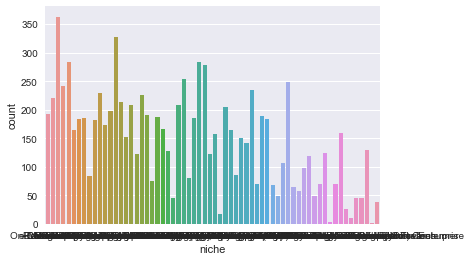

In [60]:
sns.countplot(x='niche', data=combined_results)

In [15]:
#qopts = {'query': 'DigitalOcean', 'filter': '{filter_string}', ...}
qopts = {'query': 'DigitalOcean', 'count':4}
my_query = discovery.query(environ_id, collection_id, qopts)

First get just 'matching_results'. At most 200, or get all of them iA if less than 200.

returned results at highest level is a 2-element dictionary/json

first key: matching_results
second key: results    
results (second key) is a list of json files of number 'count' from the query

In [19]:
len(my_query['results'])

4

In [65]:
company = qopts['query']
companies[companies['Watson Discovery Query Term'] == company]

,Watson Discovery Query Term,Watson Discovery Filter Term,Wiki Page Title,Company,Sales SubSector,Sales Niche,Unnamed: 6
68,DigitalOcean,NaN,Digital Ocean,Digital Ocean,Enterprise Applications,Cloud Infrastructure/Infrastructure as a Service,NaN


In [61]:
subsector = companies[companies['Watson Discovery Query Term'] == company]['Sales SubSector'].item()
subsector

'Enterprise Applications'

In [66]:
niche = companies[companies['Watson Discovery Query Term'] == company]['Sales Niche'].item()
niche

'Cloud Infrastructure/Infrastructure as a Service'

In [69]:
new_entry = {}
new_entry['id'] = my_query['results'][i]['id']
new_entry['title'] = my_query['results'][i]['title']
new_entry['text'] = my_query['results'][i]['text']
new_entry['alchemyapi_text'] = my_query['results'][i]['alchemyapi_text']

In [73]:
pd.DataFrame.from_dict(new_entry,orient='index').T

,id,title,text,alchemyapi_text
0,2bccaffa57aaeed16c017d184da7dfbe,FreshPorts - net/rubygem-fog-digitalocean,"If you buy from Amazon USA, please support us ...",PKGNAME: rubygem-fog-digitalocean\nONLY_FOR_AR...


In [78]:
nb_results

252

In [89]:
#tot_results = my_query['matching_results']
nb_results = len(my_query['results'])

#maybe if tot_results is less than 200 I might have to 1) query with count=1, 2) get tot_results, 
#3) query again with tot_results listed as the count

for i in range(nb_results):
    new_entry = {}
    if my_query['results'][j]['language'] == 'english':
        new_entry['id'] = my_query['results'][j]['id']
        new_entry['title'] = my_query['results'][j]['title']
        new_entry['text'] = my_query['results'][j]['text']
        new_entry['alchemyapi_text'] = my_query['results'][j]['alchemyapi_text']
        new_entry['subsector'] = subsector
        new_entry['niche'] = niche
        new_entry['company'] = company
        
        if i == 0 and j==0:
            news_niches_df = pd.DataFrame.from_dict(new_entry,orient='index').T
            #else df2 = pd.DataFrame(test_companies.ix[i]).T
            #and also result_df = pd.concat([row,df2])
            
        else:
            new_row = pd.DataFrame.from_dict(new_entry,orient='index').T
            news_niches_df = pd.concat([news_niches_df,new_row])
        
    else:
        continue

news_niches_df = news_niches_df.reset_index().drop(['index'],axis=1)
news_niches_df

,id,title,text,alchemyapi_text,subsector,niche,company
0,2bccaffa57aaeed16c017d184da7dfbe,FreshPorts - net/rubygem-fog-digitalocean,"If you buy from Amazon USA, please support us ...",PKGNAME: rubygem-fog-digitalocean\nONLY_FOR_AR...,Enterprise Applications,Cloud Infrastructure/Infrastructure as a Service,DigitalOcean
1,10560a0abbd06e7261f7da7da279c0e1,Arch Rivals - DevOps.com,Where the world meets DevOps\n\nArch Rivals\n\...,Arch Rival...,Enterprise Applications,Cloud Infrastructure/Infrastructure as a Service,DigitalOcean
2,2d1a1e76e5bc3f8bd722a50eed51c84c,"DigitalOcean - Releases Load Balancers, the Ea...",Log in\n\nE-mail\n\nBecome a member for free\n...,"NEW YORK, NY--(Marketwired - Feb 14, 2017) - ...",Enterprise Applications,Cloud Infrastructure/Infrastructure as a Service,DigitalOcean
3,45adb95ce5fa29305e25b03e291d87c7,DigitalOcean Named One of the Coolest Cloud In...,Menu\n\n(202) 540-8337\n\nGet RSS Feed\n\nSubm...,"Joseph Tsidulko, senior editor at CRN, said ab...",Enterprise Applications,Cloud Infrastructure/Infrastructure as a Service,DigitalOcean


In [26]:
#gate storage based on english
my_query['results'][0]['language'] == 'english'

True

In [20]:
my_query['results'][0]['id']

'2bccaffa57aaeed16c017d184da7dfbe'

In [23]:
my_query['results'][0]['title']

'FreshPorts - net/rubygem-fog-digitalocean'

In [31]:
my_query['results'][0]['text']

"If you buy from Amazon USA, please support us by using this link.\n\nPort details\n\nrubygem-fog-digitalocean Module for the 'fog' gem to support DigitalOcean 0.3.0 net =0\n\nMaintainer: sunpoet@FreeBSD.org Port Added: 14 Mar 2017 21:35:27 Also Listed In: rubygems License: MIT Fog::DigitalOcean is a module for the fog gem to support DigitalOcean. WWW: https://github.com/fog/fog-digitaloceanSVNWeb : Homepage : PortsMon\n\nTo install the port: cd /usr/ports/net/rubygem-fog-digitalocean/ && make install clean To add the package: pkg install rubygem-fog-digitalocean\n\nPKGNAME: rubygem-fog-digitalocean\n\nONLY_FOR_ARCHS: nil\n\nNOT_FOR_ARCHS: nil\n\ndistinfo: TIMESTAMP = 1489519224 SHA256 (rubygem/fog-digitalocean-0.3.0.gem) = e6fa84c0a7fc4d3ee611912f40b5e9fe28e555527990f28d345dea8515a94fff SIZE (rubygem/fog-digitalocean-0.3.0.gem) = 47104\n\nNOTE: FreshPorts displays only information on required and default dependencies. Optional dependencies are not covered.\n\nBuild dependencies:\n\nRu

In [32]:
my_query['results'][0]['alchemyapi_text']

'PKGNAME: rubygem-fog-digitalocean\nONLY_FOR_ARCHS: nil\nNOT_FOR_ARCHS: nil\ndistinfo:\nNOTE: FreshPorts displays only information on required and default dependencies.  Optional dependencies are not covered.\nThis port is required by:\n'

In [21]:
discovery_result_to_S3 = json.dumps(my_query)

In [22]:
discovery_result_to_S3

'{"matching_results": 252, "results": [{"id": "2bccaffa57aaeed16c017d184da7dfbe", "score": 3.439208, "yyyymm": "201703", "author": "About the authors", "entities": [], "taxonomy": [{"score": "0.577676", "label": "/technology and computing/programming languages/java"}, {"score": "0.510167", "label": "/law, govt and politics"}, {"confident": "no", "score": "0.190476", "label": "/technology and computing/operating systems/linux"}], "url": "http://www.freshports.org/net/rubygem-fog-digitalocean/", "usage": "By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html", "enrichedTitle": {"entities": [], "usage": "By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html", "text": "FreshPorts -- net/rubygem-fog-digitalocean", "concepts": [], "statusInfo": "unsupp

In [41]:
print(news_articles)

{"matching_results": 236, "results": [{"id": "2bccaffa57aaeed16c017d184da7dfbe", "score": 3.4388957, "yyyymm": "201703", "author": "About the authors", "entities": [], "taxonomy": [{"score": "0.577676", "label": "/technology and computing/programming languages/java"}, {"score": "0.510167", "label": "/law, govt and politics"}, {"confident": "no", "score": "0.190476", "label": "/technology and computing/operating systems/linux"}], "url": "http://www.freshports.org/net/rubygem-fog-digitalocean/", "usage": "By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html", "enrichedTitle": {"entities": [], "usage": "By accessing AlchemyAPI or using information generated by AlchemyAPI, you are agreeing to be bound by the AlchemyAPI Terms of Use: http://www.alchemyapi.com/company/terms.html", "text": "FreshPorts -- net/rubygem-fog-digitalocean", "concepts": [], "statusInfo": "unsupp